# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Part 3: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from joblib import load
from typing import Union, Tuple, List, Dict
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, RandomizedSearchCV

# magic word for producing visualizations in notebook
%matplotlib inline

PROCESSED_DATA_PATH = './data/'
IMAGE_PATH = './images/'

## Step 1. Explore the datasets

In this first step, I am going to load the pickle files related to the training and test datasets, which were already cleaned in Part 0 of the project carrying out the same steps as with the general demographics and customers datasets.Then, I am going to compare them in terms of amount of rows and columns, to see if they have the same dimensions and, if not, which columns are especially different. Finally, I will see the distributions of values in the response variable.

In [2]:
def load_data_from_pickle_file(filename: str, file_path: str = PROCESSED_DATA_PATH) -> pd.DataFrame:
    '''
    INPUT:
    filename - (string) the file name of the pickle file
    file_path - (string) the path name where the pickle file is held
    
    OUTPUT:
    data - (pandas dataframe) the dataframe object to load into a pickle file
    '''
    
    full_path = file_path + filename
    
    try:
        df_processed_data = load(full_path)
    except:
        print('Unable to load pickle file {}'.format(full_path))
        return None
    else:
        print('Loaded pickle file {}'.format(full_path))
        return df_processed_data

In [3]:
df_mailout_train = load_data_from_pickle_file(filename='processed_mailout_train_data.pk')                                        
df_mailout_train.head()

Loaded pickle file ./data/processed_mailout_train_data.pk


,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ANZ_12,...,FINANZTYP_5,FINANZTYP_6,FINANZTYP_Other,FINANZTYP_nan,ZABEOTYP_1,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_Other,ZABEOTYP_nan,RESPONSE
0,8.0,15.0,0.0,1.0,0.0,5.0,0,0,0.0,0,...,False,True,False,False,False,True,False,False,False,0
1,13.0,1.0,0.0,2.0,0.0,5.0,1,1,0.0,2,...,False,True,False,False,True,False,False,False,False,0
2,9.0,0.0,0.0,0.0,0.0,1.0,0,1,0.0,0,...,True,False,False,False,False,True,False,False,False,0
3,6.0,4.0,0.0,2.0,0.0,2.0,0,0,0.0,0,...,True,False,False,False,False,True,False,False,False,0
4,9.0,53.0,0.0,1.0,0.0,4.0,0,0,0.0,0,...,True,False,False,False,False,True,False,False,False,0


In [4]:
df_mailout_test = load_data_from_pickle_file(filename='processed_mailout_test_data.pk')
df_mailout_test.head()

Loaded pickle file ./data/processed_mailout_test_data.pk


,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ANZ_12,...,FINANZTYP_2,FINANZTYP_5,FINANZTYP_6,FINANZTYP_Other,FINANZTYP_nan,ZABEOTYP_1,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_Other,ZABEOTYP_nan
0,7.0,2.0,0.0,2.0,0.0,6.0,0,0,0.0,1,...,False,True,False,False,False,False,True,False,False,False
1,0.0,20.0,0.0,1.0,0.0,7.0,0,0,0.0,0,...,False,False,True,False,False,False,True,False,False,False
2,16.0,2.0,0.0,4.0,0.0,1.0,0,0,0.0,0,...,True,False,False,False,False,False,True,False,False,False
3,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.0,0,...,False,False,True,False,False,False,True,False,False,False
4,21.0,1.0,0.0,4.0,0.0,6.0,3,4,10.0,4,...,False,False,True,False,False,False,False,True,False,False


In [5]:
print('Shape of train dataset: ', df_mailout_train.shape)
print('Shape of test dataset: ', df_mailout_test.shape)

Shape of train dataset:  (35000, 353)
Shape of test dataset:  (34992, 352)


In [6]:
print('Columns not held in test dataset: ', set(df_mailout_train.columns).difference(df_mailout_test.columns))

Columns not held in test dataset:  {'RESPONSE'}


The test dataset does not hold the response; therefore, I am going to work only with the train dataset. The trained model will be tested using the k-fold Cross-Validation technique as suggested in [3].

In [7]:
round(df_mailout_train['RESPONSE'].value_counts(normalize=True)*100, 2)

RESPONSE
0    98.76
1     1.24
Name: proportion, dtype: float64

The train dataset is highly imbalanced as only 1.24% of the responses have 1s. To balance this dataset, I will use the Synthetic Minority Oversampling Technique (SMOTE for short) as suggested in [1].

## Step 2. Building the preliminary pipeline for model selection

In this step, I am going to fit four different supervised ML models and make predictions on the transformed training dataset, where the same normalization technique as in step 1 of the project will be applied, together with the SMOTE technique. Based on the overall results of the metric scores in the fit and prediction phases, I will select the most suitable ML model.

### Step 2.1. Preparing the data

Prior to evaluate the models, we need some data preparation. First, I am going to save in a new dataset the response column (y) of the training dataset (X) and, then, drop it. Second, I am going to define the objects related to the four ML models to be evaluated: logistic regression, gaussian naive bayes, decision tree and random forest. Third, I will define the metrics to be used for evaluation: accuracy, precision, recall and f1, being recall the most important to study for this application (as the company wants to maximize the number of responses to the email sent to the potential customers). Finally, I will define the set of k-neighbors to use for fitting the SMOTE object.      

In [8]:
# Applying step 1.
target = df_mailout_train['RESPONSE']
df_mailout_train.drop('RESPONSE', axis=1, inplace=True)

In [9]:
# Applying step 2. As in this step, I am not going to fin-tune any model, I will only use the random_state hyperparameter and 
# set to 42 to ensure the reproducibility of the results
models= [('LR', LogisticRegression(random_state=42)),
         ('NB', GaussianNB()), 
         ('DT', DecisionTreeClassifier(random_state=42)),
         ('RF', RandomForestClassifier(random_state=42))]

In [10]:
# Applying step 3.
metrics = ['accuracy', 'precision', 'recall', 'f1']

In [11]:
# Applying step 4. The default value for the k-neiggbors is 5, so I am going to start with that value and increase until 9.
k_values = [5, 7, 9]

### Step 2.2. Evaluating the models

The original paper on SMOTE [2] suggested combining SMOTE with random undersampling of the majority class. We can update the training subset to first oversample the minority class to have 10% (i.e, 0.1) the number of examples of the majority class and, then, use random undersampling to reduce the number of examples in the majority class to have 50% (i.e, 0.5) more than the minority class. With this data transformation together with the prior normalization of the subset using the robust scaler as in part 1, we can fit and predict on the four models using a cross validation on a repeated stratified k-folders. The latter is also a well-known technique from improving the balance of classes in the training and test subsets.

In [12]:
def evaluate(X: pd.DataFrame, y: pd.Series, 
             models: Tuple[str, Union[LogisticRegression, GaussianNB, DecisionTreeClassifier, RandomForestClassifier]], 
             metrics: List[str], k_values: List[int], n_splits: int = 5, n_repeats: int = 5) -> Dict[str, Dict[int, Dict[str, float]]]:

    '''
    This function evaluates each ML classifier within the pipeline settings for the samplers returning the desired metrics
    scores together with the fit and predict times

    INPUT: 
        models(list of tuples)      - A list of tuples with the ML names and their objects to be evaluated.
        metrics (list of strings)   - A list of metric names to be used for evaluating each ML in the pipelines.  
        k_values (list of integers) - A list of values for the number of nearest neighbors to be used to define the 
                                      neighborhood of samples to use to generate the synthetic sample in SMOTE
        n_splits (integer)          - Number of splits of the given dataset (default 5)
        n_repéats (integer)         - Number of repetions for each split (default 5)
        
    OUTPUT: 
        results (dict of dict) - A list of dictionaries (one for each ML) holding the metric scores and times for the train and
                                 test sets.
    '''

    # Creating the train and test sets using a repeated stratified k-folders 
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
    
    # Looping over the ML models
    results = {}
    for model in models:
        name = model[1].__class__.__name__
        print('Working with classifier: ', name)
    
        # Looping over the number of nearest neighbors
        results[name] = {}
        for i, k in enumerate(k_values):
            print(' k_neighbors: ', k)
            
            # Creating the pipeline for the specific number of neighbors and ML model
            pipeline_steps = [('RS', RobustScaler()), 
                              ('OS', SMOTE(sampling_strategy=0.1, k_neighbors=k, random_state=42)),
                              ('US', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
                              model]
            
            pipeline = Pipeline(steps=pipeline_steps)
            
            # Conducting the cross validation for the built pipeline
            m_results = cross_validate(pipeline, X, y, scoring=metrics, cv=cv, n_jobs=-1, verbose=5, return_train_score=True)
    
            # Computing the average values of all metric scores and times
            results[name][i] = {}
            for m_res, vals in m_results.items():
                results[name][i][m_res] = vals.mean()
    
            print(results[name][i])
        
    return results

results = evaluate(df_mailout_train, target, models, metrics, k_values)

Working with classifier:  LogisticRegression
 k_neighbors:  5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   21.1s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   25.4s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   26.9s finished


{'fit_time': 4.774972009658813, 'score_time': 0.4682624626159668, 'test_accuracy': 0.8324057142857143, 'train_accuracy': 0.8403885714285714, 'test_precision': 0.018686781286652868, 'train_precision': 0.040855505968105214, 'test_recall': 0.24229885057471268, 'train_recall': 0.5267816091954023, 'test_f1': 0.03469529776770718, 'train_f1': 0.07582778962526525}
 k_neighbors:  7


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   14.2s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   20.3s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   21.8s finished


{'fit_time': 4.431180267333985, 'score_time': 0.4294209671020508, 'test_accuracy': 0.8320571428571428, 'train_accuracy': 0.8404200000000001, 'test_precision': 0.018835301756568206, 'train_precision': 0.04114084549970547, 'test_recall': 0.24505747126436783, 'train_recall': 0.5308045977011494, 'test_f1': 0.03497967020902459, 'train_f1': 0.07636096048599476}
 k_neighbors:  9


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   14.3s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   19.8s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   21.3s finished


{'fit_time': 4.328838586807251, 'score_time': 0.4092740535736084, 'test_accuracy': 0.8320571428571428, 'train_accuracy': 0.8396857142857143, 'test_precision': 0.018904488806949643, 'train_precision': 0.04150303128711237, 'test_recall': 0.2459770114942529, 'train_recall': 0.5383908045977012, 'test_f1': 0.03510689103123681, 'train_f1': 0.07706280860369195}
Working with classifier:  GaussianNB
 k_neighbors:  5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   13.1s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   18.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   19.8s finished


{'fit_time': 2.978617858886719, 'score_time': 0.607437219619751, 'test_accuracy': 0.5731714285714286, 'train_accuracy': 0.5741214285714286, 'test_precision': 0.016005605911051768, 'train_precision': 0.017968217781947165, 'test_recall': 0.5517241379310345, 'train_recall': 0.6190804597701149, 'test_f1': 0.031104422497783665, 'train_f1': 0.034918411044051224}
 k_neighbors:  7


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   13.5s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   19.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   21.3s finished


{'fit_time': 3.1951088809967043, 'score_time': 0.6464859867095947, 'test_accuracy': 0.5717085714285713, 'train_accuracy': 0.5733328571428572, 'test_precision': 0.015947195352286423, 'train_precision': 0.01803029548403454, 'test_recall': 0.5512643678160919, 'train_recall': 0.6224137931034481, 'test_f1': 0.030993203875852898, 'train_f1': 0.035040541063832274}
 k_neighbors:  9


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   13.2s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   19.2s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   20.3s finished


{'fit_time': 3.084814805984497, 'score_time': 0.6577703762054443, 'test_accuracy': 0.5784857142857143, 'train_accuracy': 0.57921, 'test_precision': 0.01621928516832153, 'train_precision': 0.018203918520421004, 'test_recall': 0.552183908045977, 'train_recall': 0.6196551724137931, 'test_f1': 0.031507399322107416, 'train_f1': 0.0353632494739096}
Working with classifier:  DecisionTreeClassifier
 k_neighbors:  5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   15.0s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   21.1s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   22.7s finished


{'fit_time': 4.6279123020172115, 'score_time': 0.3697604751586914, 'test_accuracy': 0.9103257142857143, 'train_accuracy': 0.9363042857142857, 'test_precision': 0.016971765682416203, 'train_precision': 0.1634872213438478, 'test_recall': 0.1089655172413793, 'train_recall': 1.0, 'test_f1': 0.029361466839086404, 'train_f1': 0.28098335017193005}
 k_neighbors:  7


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   17.4s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   21.8s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   23.3s finished


{'fit_time': 5.107577505111695, 'score_time': 0.3736500930786133, 'test_accuracy': 0.9091371428571429, 'train_accuracy': 0.9369328571428572, 'test_precision': 0.014612929478778978, 'train_precision': 0.1649197846845986, 'test_recall': 0.09517241379310346, 'train_recall': 1.0, 'test_f1': 0.02532416603551855, 'train_f1': 0.2830820774170373}
 k_neighbors:  9


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   13.9s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   20.0s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   21.2s finished


{'fit_time': 4.324973363876342, 'score_time': 0.3683258247375488, 'test_accuracy': 0.90924, 'train_accuracy': 0.9370928571428572, 'test_precision': 0.015095926454415116, 'train_precision': 0.1653064835840566, 'test_recall': 0.09793103448275861, 'train_recall': 1.0, 'test_f1': 0.026152048507489103, 'train_f1': 0.28364442068234796}
Working with classifier:  RandomForestClassifier
 k_neighbors:  5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   26.7s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   38.3s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   41.7s finished


{'fit_time': 8.685750617980958, 'score_time': 0.7305037117004395, 'test_accuracy': 0.9875714285714285, 'train_accuracy': 1.0, 'test_precision': 0.0, 'train_precision': 1.0, 'test_recall': 0.0, 'train_recall': 1.0, 'test_f1': 0.0, 'train_f1': 1.0}
 k_neighbors:  7


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   28.8s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   40.6s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   44.7s finished


{'fit_time': 9.35455060005188, 'score_time': 0.8055398464202881, 'test_accuracy': 0.9875714285714285, 'train_accuracy': 0.9999985714285714, 'test_precision': 0.0, 'train_precision': 1.0, 'test_recall': 0.0, 'train_recall': 0.9998850574712644, 'test_f1': 0.0, 'train_f1': 0.9999424460431655}
 k_neighbors:  9


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   28.9s remaining:   16.2s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   40.9s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   44.4s finished


{'fit_time': 9.399422645568848, 'score_time': 0.7756704330444336, 'test_accuracy': 0.9875714285714285, 'train_accuracy': 0.9999985714285714, 'test_precision': 0.0, 'train_precision': 0.9998853868194842, 'test_recall': 0.0, 'train_recall': 1.0, 'test_f1': 0.0, 'train_f1': 0.9999426111908178}


In [13]:
results

{'LogisticRegression': {0: {'fit_time': 4.774972009658813,
   'score_time': 0.4682624626159668,
   'test_accuracy': 0.8324057142857143,
   'train_accuracy': 0.8403885714285714,
   'test_precision': 0.018686781286652868,
   'train_precision': 0.040855505968105214,
   'test_recall': 0.24229885057471268,
   'train_recall': 0.5267816091954023,
   'test_f1': 0.03469529776770718,
   'train_f1': 0.07582778962526525},
  1: {'fit_time': 4.431180267333985,
   'score_time': 0.4294209671020508,
   'test_accuracy': 0.8320571428571428,
   'train_accuracy': 0.8404200000000001,
   'test_precision': 0.018835301756568206,
   'train_precision': 0.04114084549970547,
   'test_recall': 0.24505747126436783,
   'train_recall': 0.5308045977011494,
   'test_f1': 0.03497967020902459,
   'train_f1': 0.07636096048599476},
  2: {'fit_time': 4.328838586807251,
   'score_time': 0.4092740535736084,
   'test_accuracy': 0.8320571428571428,
   'train_accuracy': 0.8396857142857143,
   'test_precision': 0.01890448880694964

### Step 2.3. Selecting the best model

Now that we have all the metric scores as well as the fit and score times for each model, it is time to analize them and decide on which model performs the best. To this end, I am going to print, first, four different bar plots (one for each metric score showing its average values for each combination of model and k-neighbors value). Then, I will print the overall running times of each model as well as their breakdown by fit and score times.  

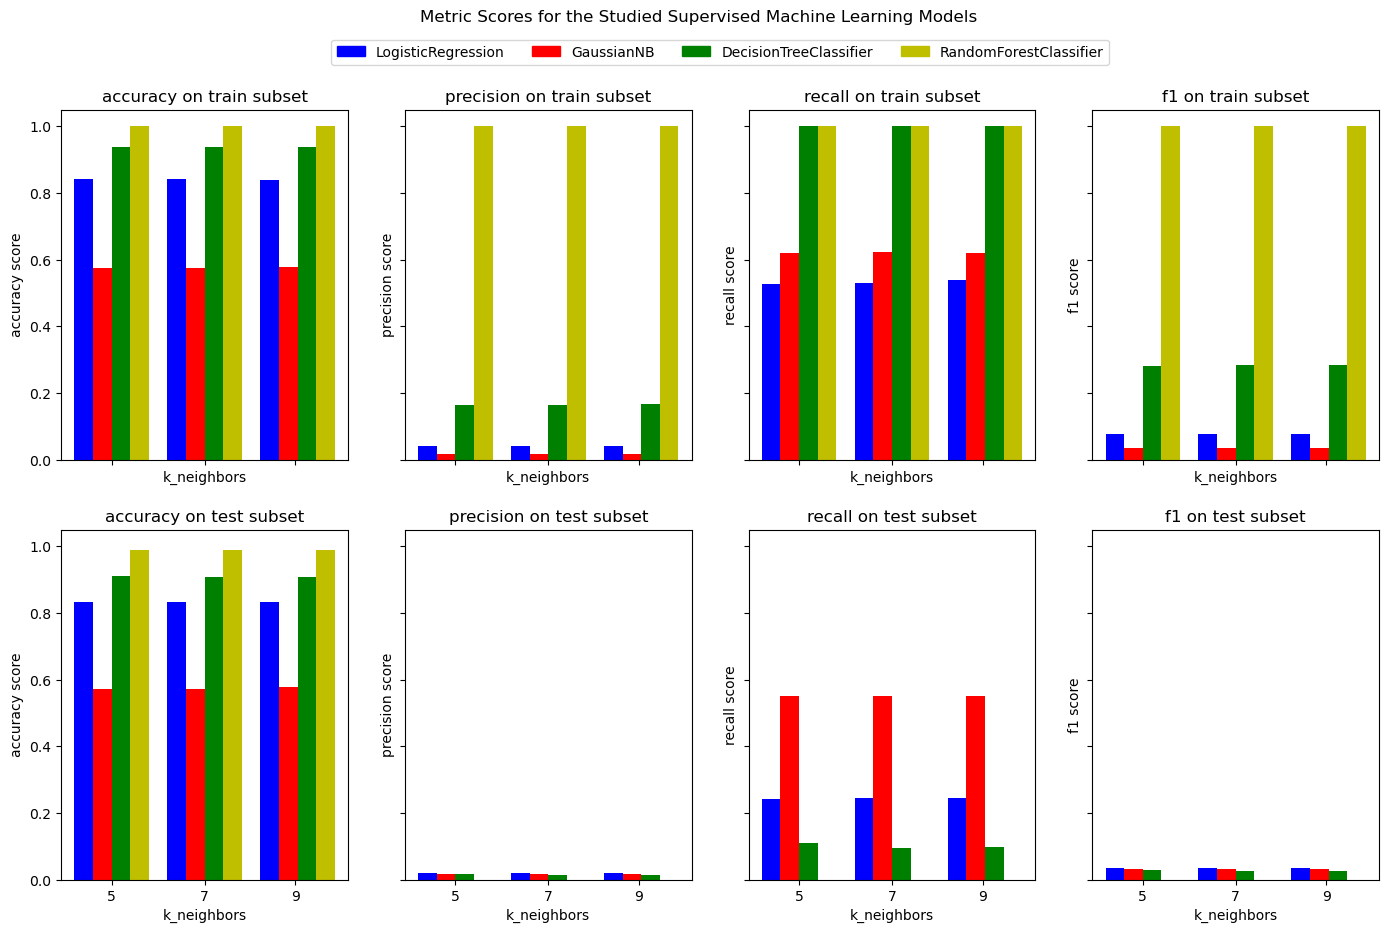

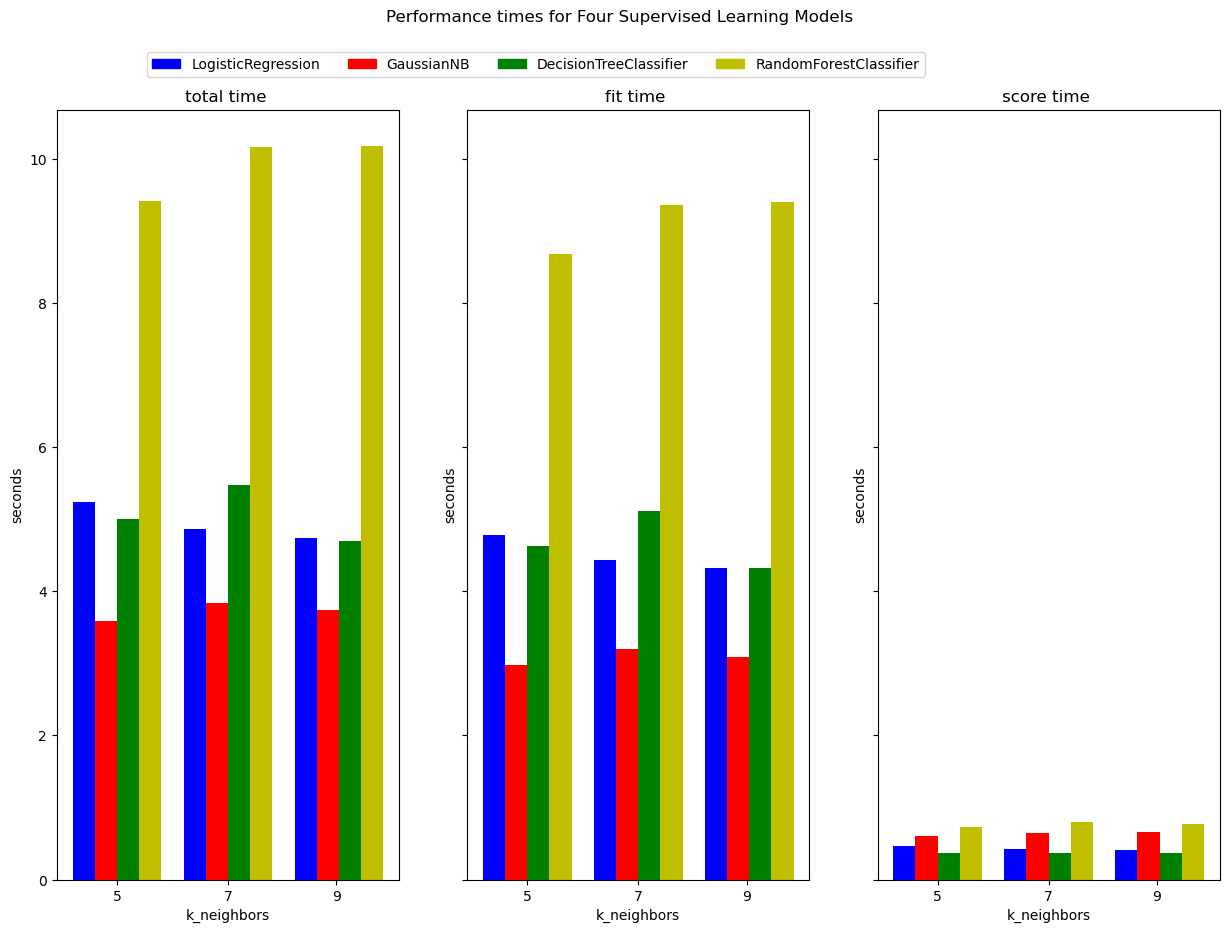

In [14]:
def plot_metrics(results: Dict[str, Dict[int, Dict[str, float]]], metrics: List[str], k_values: List[int]) -> None:

    '''
    This function plots the metric scores for each combination of k-values and ML models used in the cross validation

    INPUT: 
        results (dict of dict) - A list of dictionaries (one for each ML) holding the metric scores and times for the train 
                                 and test sets.
        metrics (list of strings)   - A list of metric names to be used for plotting the scores related to each ML.  
        k_values (list of integers) - A list of values for the number of nearest neighbors used to generate the synthetic sample in SMOTE
        
    OUTPUT: None
    '''
    
    fig = plt.figure(figsize = (17, 10))
    axis = fig.subplots(2, 4, sharex=True, sharey=True)

    bar_width = 0.2
    colors = ['b','r','g', 'y']

    # Looping over the datasets
    for i, data in enumerate(['train', 'test']):
    
        # Looping over the metrics
        for j, metric in enumerate(metrics):
            
            # Setting up the plot attributes to its proper values 
            axis[i,j].set_xticks([0.3, 1.3, 2.275])    
            axis[i,j].set_xticklabels(k_values)   
            axis[i,j].set_title(metric + " on " + data + " subset") 
            axis[i,j].set_xlabel("k_neighbors")
            axis[i,j].set_ylabel(metric + " score")
            
            # Looping over the models
            for k, model in enumerate(results):
          
                # Looping over the k-values
                for l, k_val in enumerate(k_values):
                    axis[i,j].bar(l+k*bar_width, results[model][l][data + '_' + metric], width = bar_width, color = colors[k])
    
    plt.suptitle("Metric Scores for the Studied Supervised Machine Learning Models", fontsize = 12)
    
    # Create patches for the legend
    patches = [mpatches.Patch(color = colors[i], label = model) for i, model in enumerate(results)]
    plt.legend(handles = patches, bbox_to_anchor = (-1.3, 2.4), loc = 'upper center', borderaxespad = 0., ncol = 4)
        
    # Save all plots as an png image
    fig.savefig(IMAGE_PATH + 'ML_Scores.png', format='png')
    
    
def plot_times(results: Dict[str, Dict[int, Dict[str, float]]], metrics: List[str], k_values: List[int]) -> None:
    '''
    This function plots the times for fitting and scoring each combination of k-values and ML models used in the cross 
    validation

    INPUT: 
        results (dict of dict) - A list of dictionaries (one for each ML) holding the metric scores and times for the train 
                                 and test sets.
        metrics (list of strings)   - A list of metric names to be used for plotting the times related to each ML.  
        k_values (list of integers) - A list of values for the number of nearest neighbors used to generate the synthetic sample in SMOTE
        
    OUTPUT: None
    '''
    
    fig = plt.figure(figsize = (15, 10))
    axis = fig.subplots(1, 3, sharey=True)

    bar_width = 0.2
    colors = ['b','r','g', 'y']

    # Computing the total time
    for model in results:
        for k, k_val in enumerate(k_values):
            results[model][k]['total_time'] = results[model][k]['fit_time'] + results[model][k]['score_time']  

    # Looping over the time components
    for i, time in enumerate(['total', 'fit', 'score']):
    
        axis[i].set_xticks([0.3, 1.3, 2.275])    
        axis[i].set_xticklabels(k_values)   
        axis[i].set_title(time + " time ") 
        axis[i].set_xlabel("k_neighbors")
        axis[i].set_ylabel("seconds")
    
        # Looping over the models
        for j, model in enumerate(results):
    
            # Looping over the k-values
            for k, k_val in enumerate(k_values):
                axis[i].bar(k+j*bar_width, results[model][k][time + '_time'], width = bar_width, color = colors[j])

    plt.suptitle("Performance times for Four Supervised Learning Models", fontsize = 12)

    patches = [mpatches.Patch(color = colors[i], label = model) for i, model in enumerate(results)]
    plt.legend(handles = patches, bbox_to_anchor = (-1, 1.075), loc = 'upper center', borderaxespad = 0., ncol = 4)

    # Save all plots as an png image
    fig.savefig(IMAGE_PATH + 'ML_times.png', format='png')
    
plot_metrics(results, metrics, k_values)
plot_times(results, metrics, k_values)

### Results discussion
By looking at the two above figures, we can see that
- The number of k-neighbors for the overfitting sampler does not seem to affect on the results for any of the models.
- Fitting and score times are rather similar for all models regardless of the number of k-neighbors, except for the random forest classifier, which doubles or triples them depending on the k value.
- Accuracy is rather good for all models except for the gaussian naive bayes, where that metric is regular (i.e., around 60%).  
- Precision and f1 metrics are only good for the random forest classifier on the training subset, and almost 0 for the test subset. So, this model seems to be overfitted.
- Recall metric is only good for the decision tree and random forest classifiers on the training subset, and very bad for the test subset (i.e., values not greater than 10%). So, these models seem to be again overfitted. However, for the gaussian naive bayes, the recall has a regular score for both subsets (i.e., around 55% for the training subset and 60% for the test subset).  

Under these results, I would suggest to choose the gaussian naive bayes as the recall is the most important metric for the company (i.e, it is vital to send the emails to the customers that are really willing to be interested in the company services), despite of having worse scores for the accuracy. Furthermore, it is the fastest running model by far.

## Step 4. Final pipeline for fine-tunning the gaussian naive bayes model

In this last step, I will try to improve the performance of the outstanding model, the gaussin naive bayes. The idea is to have a higher score for the recall, while not worsening too much the other metrics, specially accuracy. To this end, I will carry out a randomized grid search on the var_smoothing hyperparameter, which is the only hyperparameter to tune in that model. 
I decided to use this search instead of going through all the values of var_smoothing (i.e., grid search) as it is very time consuming. Therefore, the optimal setting may not be found, but it can keep a good tradeoff between time and metric score.
The amount of combinations to be sought is defined by 'n_iter' parameter. Furthermore, I will set the recall metric as the refit goal, so that the search will be focused on determining the var_smoothing value maximizing the recall. With the optimal var_smoothing, I will carry out a comparison of its metric scores to the ones previously found (without fine tuning).  

In [15]:
# Redefining the metrics to be used in the randomized grid search 
metrics = ['accuracy', 'precision', 'recall', 'f1']

In [16]:
# Redefining the pipeline for only 5 k_neighbors and the gaussian naive bayes model. Since we did not observe any differences
# on higher values of k_neighbors for any of the models, we don't need to search over this parameter.
pipeline = Pipeline([('RS', RobustScaler()), 
                     ('OS', SMOTE(sampling_strategy=0.1, k_neighbors=5, random_state=42)),
                     ('US', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
                     ('NB', GaussianNB())])

In [17]:
# Taking a look at the pipeline params to know the exact name of the var_smoothing hyperparameter
pipeline.get_params()

{'memory': None,
 'steps': [('RS', RobustScaler()),
  ('OS', SMOTE(random_state=42, sampling_strategy=0.1)),
  ('US', RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
  ('NB', GaussianNB())],
 'verbose': False,
 'RS': RobustScaler(),
 'OS': SMOTE(random_state=42, sampling_strategy=0.1),
 'US': RandomUnderSampler(random_state=42, sampling_strategy=0.5),
 'NB': GaussianNB(),
 'RS__copy': True,
 'RS__quantile_range': (25.0, 75.0),
 'RS__unit_variance': False,
 'RS__with_centering': True,
 'RS__with_scaling': True,
 'OS__k_neighbors': 5,
 'OS__n_jobs': None,
 'OS__random_state': 42,
 'OS__sampling_strategy': 0.1,
 'US__random_state': 42,
 'US__replacement': False,
 'US__sampling_strategy': 0.5,
 'NB__priors': None,
 'NB__var_smoothing': 1e-09}

In [18]:
# Specifing the values for the var_smoothing hyperparameter
parameters = {'NB__var_smoothing': np.logspace(0, -9, num=100)}

In [19]:
# Creating the train and test sets using the same repeated stratified k-folders setting as in the cross-validation 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

In [20]:
# Setting up the randomized grid search for 10 combinations only
rs = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters, scoring=metrics, n_iter=20, cv=cv, 
                        verbose=3, n_jobs=-1, random_state=42, return_train_score=True, refit="recall")

In [21]:
# Fitting the randomized search is enough to get the training and test metric scores as the repeated stratified k-folders 
# already splits the given dataset into distinct training and test subsets for each folder
rs.fit(df_mailout_train, target)

Fitting 25 folds for each of 20 candidates, totalling 500 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=42),
                   estimator=Pipeline(steps=[('RS', RobustScaler()),
                                             ('OS',
                                              SMOTE(random_state=42,
                                                    sampling_strategy=0.1)),
                                             ('US',
                                              RandomUnderSampler(random_state=42,
                                                                 sampling_strategy=0.5)),
                                             ('NB', GaussianNB())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'NB__var_smoothing': array([1.0000000...
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   random_state=42, refit='recall', return_train_score=True,
                   scoring=['accuracy', 'precision', 'recall', 'f1'],
                   verbose=3)

In [22]:
# Generating the report for comparing the metric scores before and after the fine-tuning
print("Best Parameters: ", rs.best_params_)

for metric in metrics:
    print(metric)
    train_score0 = results['GaussianNB'][0]['train_' + metric]
    train_score1 = rs.cv_results_['split' + str(rs.best_index_) + '_train_' + metric].mean()
    print('  train score: prelim={}, fined-tune={}, improvement={}'.format(train_score0, train_score1, train_score1-train_score0))
          
    test_score0 = results['GaussianNB'][0]['test_' + metric]
    test_score1 = rs.cv_results_['split' + str(rs.best_index_) + '_test_' + metric].mean()
    print('  test score: prelim={}, fined-tune={}, improvement={}'.format(test_score0, test_score1, test_score1-test_score0))

Best Parameters:  {'NB__var_smoothing': 1.0}
accuracy
  train score: prelim=0.5741214285714286, fined-tune=0.5028535714285713, improvement=-0.07126785714285722
  test score: prelim=0.5731714285714286, fined-tune=0.49222857142857135, improvement=-0.0809428571428572
precision
  train score: prelim=0.017968217781947165, fined-tune=0.017514783953297426, improvement=-0.0004534338286497387
  test score: prelim=0.016005605911051768, fined-tune=0.016627092148888807, improvement=0.0006214862378370392
recall
  train score: prelim=0.6190804597701149, fined-tune=0.660919540229885, improvement=0.04183908045977003
  test score: prelim=0.5517241379310345, fined-tune=0.6471264367816092, improvement=0.09540229885057472
f1
  train score: prelim=0.034918411044051224, fined-tune=0.034017661188653216, improvement=-0.0009007498553980087
  test score: prelim=0.031104422497783665, fined-tune=0.032326902964391405, improvement=0.00122248046660774


### Report Discussion
From the report, we can see that setting the **var_smoothing to 1 improves the recall metric by 4.2% and 9.5% in the train and test subsets**, respectively; while the other metrics has not being substantially worsening. For example, the **accuracy is now 7.1% and 8% worse in the train and test subsets**, respectively. However, this is not a big concern as it is more important the recall metric for that application. 

# References

1. [Brownlee J (2021). SMOTE for Imbalanced Classification with Python. Machine Learning Mastery. March 17, 2021](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
2. Nitesh V. Chawla, Kevin W. Bowyer, Lawrence O. Hall, W. Philip Kegelmeyer (2002).SMOTE: Synthetic Minority Over-sampling Technique. Journal of Artificial Intelligence Research 16: 321–357.
3. [Brownlee J (2023). A Gentle Introduction to k-fold Cross-Validation. Machine Learning Mastery. October 4, 2023](https://machinelearningmastery.com/k-fold-cross-validation/)